# 不等流計算4:一般断面の不等流計算3-分割断面法+分割断面間の干渉を考慮（平均流速公式レベル3）

## 課題1

以下に示す平均流速公式レベル3のコードの概要を理解すること。
fortranのコードをそのまま移植したため汚いです。

In [1]:
import matplotlib.pyplot as plt
import numpy as np

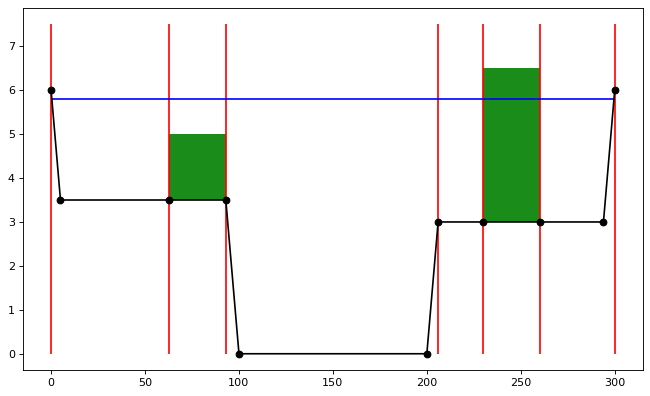

In [2]:
plt.figure(figsize=(10,6), dpi=80)
           
x=np.array( [0,5,63,93,100,200,206,230,260,294,300] )
y=np.array( [6, 3.5, 3.5, 3.5,  0,  0,  3, 3, 3, 3,  6] )
div = np.array( [0,63,93,206,230,260,300] )
plt.plot(x,y, c='k', marker='o')
plt.vlines(div, ymin=0, ymax=7.5, color='r')
plt.axvspan(xmin=30, xmax=60, ymin=3.5, ymax=4.5, color='blue', alpha=0.1)
plt.fill_between([63,93], 3.5, 5.0, facecolor='green', alpha=0.9) # Tree height 1.5m
plt.fill_between([230,260], 3.0, 6.5, facecolor='green', alpha=0.9) # Tree height 3.5m
plt.hlines(xmin=0,xmax=300,y=5.8, color='b') # water level
plt.show()

### class

#### matrix solver

In [3]:
def matrixsolver(a,b,c,d):
    
### 2x2の行列はTDMAを使えないので普通に計算を行なう
    if len(a) == 2 :
        x = np.empty_like(a)
        tmp = 1.0/(b[0]*b[1] - a[1]*c[0])
        r11 = tmp*b[1]
        r12 = tmp*-c[0]
        r21 = tmp*-a[1]
        r22 = tmp*b[0]
        x[0] = d[0]*r11 + d[1]*r12
        x[1] = d[0]*r21 + d[1]*r22
        
    elif len(a) >= 3 :
        x, P, Q = np.empty_like(a), np.empty_like(a), np.empty_like(a)
        n = len(x)
        
        P[0], Q[0] = -c[0]/b[0], d[0]/b[0]
        for i in range(1, n):
            P[i] = -  c[i]                /(a[i]*P[i-1] + b[i])
            Q[i] =  (-a[i]*Q[i-1] + d[i])/(a[i]*P[i-1] + b[i])
            
        x[-1] = Q[-1]
        for i in range(n-2, -1, -1):
            x[i] = P[i]*x[i+1] + Q[i]
        
    else:
        print('error')
    return x

#### subsecbound

In [4]:
class subsectBound(object):
    def __init__(self, f, fd):
        self.f = f
        self.fd = fd
        self.Swd = np.nan
        self.Swl = np.nan
        self.Swr = np.nan

#### subsection

In [5]:
class subsection(object):
    def __init__(self, x, y, n,treeh):
        self.x = x
        self.y = y
        self.n = n
        self.treeh = treeh

    def H2ABSKn(self, H): #変更:引数は水位のみ
        A, B, S, SN = float(0), float(0), float(0), float(0)
        x = self.x 
        y = self.y + self.treeh #変更: + 樹高
        n = self.n 
        
        for i in range(1, len(x)):
            dx = x[i] - x[i-1]    
            dy = y[i] - y[i-1]    
            hb, hf = H - y[i-1], H - y[i]
            
            if hb <= float(0) :
                if hf > float(0) :
                    dx_dh = dx / (hf - hb)
                    B += hf * dx_dh
                    A += 0.5 * hf * hf * dx_dh
                    Sp = hf * np.sqrt( dx_dh * dx_dh + 1.0)
                    S +=  Sp
                    SN += Sp * n[i-1]**1.5
            elif hf <= float(0) :
                if hb > float(0) :
                    dx_dh = dx / (hf - hb)
                    B -= hb * dx_dh
                    A -= 0.5 * hb * hb * dx_dh
                    Sp = hb * np.sqrt(dx_dh * dx_dh + 1.0)
                    S += Sp
                    SN += Sp * n[i-1]**1.5
            else :
                B += dx
                A += 0.5 * dx * (hf + hb)
                Sp = np.sqrt(dx**2 + dy**2)
                S += Sp
                SN += Sp * n[i-1]**1.5
                
        if S <= float(0):
            nd = float(0)
            K = float(0)
        else:
            nd = (SN/S)**(2.0/3.0)
            K = A**(5.0/3.0)/nd/S**(2.0/3.0)
            
        return A, B, S, K, nd

#### section

In [50]:
class section(object):
    def __init__(self, X, Y, N, distance=np.nan, treeh=np.nan, subsectBoundf=np.nan, subsectBoundfd=np.nan):
        self._subsections = [subsection(x,y,n,h) for x,y,n,h in zip(X,Y,N,treeh)]
        self._subsectBounds = [subsectBound(f, fd) for f, fd in zip(subsectBoundf, subsectBoundfd)]
        self.distance = distance
        
    def H2ABSKnSub(self, H):
        num = len(self._subsections)
        A = np.zeros(num)
        B = np.zeros(num)
        S = np.zeros(num)
        K = np.zeros(num)
        n = np.zeros(num)
            
        for nump in range(num) : 
            A[nump], B[nump], S[nump], K[nump], n[nump] = self._subsections[nump].H2ABSKn(H)
            
        return A, B, S, K, n
    
    def H2ABSKRc(self, H):
        A, B, S, K, n = self.H2ABSKnSub(H)
        
        RA = float(0)
        for i in range(len(A)):
            if A[i] > 0 : RA += A[i]*(A[i]/S[i])**(2/3)
        Rc = (RA/A.sum())**1.5
        
        return A.sum(), B.sum(), S.sum(), K.sum(), Rc
    
    def zbmin(self): #樹木群を考慮
        return np.array([s.y.min() + s.treeh for s in self._subsections]).min()
    
    def A2H(self, A):
        Ht = self.zbmin() + float(0.01)
        f = 1.0
        dfdh = 1.0
        while np.abs(f/dfdh) > 10**(-8): # 反復計算の収束条件
            At, Bt, St, _, _ = self.H2ABSKRc(Ht)
            f = A - At
            dfdh = -Bt
            Ht -= f/dfdh
            
        return Ht
    
    # 特殊な処理：隣り合う分割断面に両方樹木があり、かつ樹高が異なる場合、それぞれの分割断面でSwが異なる。
    #そのため、Swl：左岸側からみた潤辺長, Swr:右岸側を定義
    def _setMixLength(self, H):
        subB = self._subsectBounds
        ss = self._subsections
        num = len(subB)
        zero = float(0)
        
        n = 0
        subB[n].Swl = zero
        subB[n].Swr = zero
        dep = H - ss[n].y[0] - ss[n].treeh
        subB[n].Swd = dep if dep > zero else zero
            
        n = num-1
        subB[n].Swl = zero
        subB[n].Swr = zero
        dep = H - ss[n-1].y[-1] - ss[n-1].treeh
        subB[n].Swd = dep if dep > zero else zero
        
        for n in range(1, num-1):
            dep = np.max([H - ss[n].y[0], zero])
            if dep > 0.0 :
                treeh = np.max([ss[n-1].treeh, ss[n].treeh])
                if dep <= treeh:
                    subB[n].Swd = zero
                    if ss[n-1].treeh > ss[n].treeh :
                        subB[n].Swl = zero
                        subB[n].Swr = np.max([dep - ss[n].treeh, zero])
                    else:
                        subB[n].Swl = np.max([dep - ss[n-1].treeh, zero])
                        subB[n].Swr = zero
                else:
                    subB[n].Swd = np.max([dep-treeh, zero])
                    if ss[n-1].treeh > ss[n].treeh :
                        subB[n].Swl = zero
                        subB[n].Swr = np.max([ss[n-1].treeh-ss[n].treeh, zero]) 
                    else:
                        subB[n].Swl = np.max([-ss[n-1].treeh+ss[n].treeh, zero])
                        subB[n].Swr = zero
            else:
                subB[n].Swd = zero
                subB[n].Swl = zero
                subB[n].Swr = zero
                
                
    def HQ2IeAlphaBetaVsub(self, H, Q):
        zero = float(0)
        As, Bs, Ss, Ks, ns = self.H2ABSKnSub(H)
        d = self._setMixLength(H)
        subB = self._subsectBounds
        Vsub = np.zeros(len(self._subsections))
        
        index,  = np.where(As>0) # 河積0以上の分割断面のインデックスを取得
        
        if len(index)==1:
            n = index[0]
            Vsub[n] = Q/As[n]
        else: # 反復計算が必要
            coefA = np.zeros(len(index))
            coefB = np.zeros_like(coefA)
            coefC = np.zeros_like(coefA)
            Xnt= np.zeros_like(coefA) # 求める解 Vsub/sqrt(I)
            
            #反復計算の初期値はマニング則で与える。=摩擦損失のみを考慮 Vsub/sqrt(I)
            for i, ne in enumerate(index) : 
                Xnt[i] = 1.0/ns[ne]*(As[ne]/Ss[ne])**(2.0/3.0)
                
# ニュートン法
            for ite in range(1000):
# 係数を計算する
                for i, ne in enumerate(index) : 
                    subBL, subBR = subB[ne], subB[ne+1]
                
                    cf = ns[ne]**2.0/As[ne]**(1.0/3.0)*Ss[ne]**(4.0/3.0)
                    
                    if subBL.Swd > zero :
                        if ne == 0 : #左岸端の断面
                            sg1 = 1.0
                            coefA[i] = -sg1*subBL.fd * subBL.Swd/9.8*(Xnt[i])
                        else:
                            sg1 = np.sign(Xnt[i] - Xnt[i-1])
                            coefA[i] = -sg1*subBL.fd * subBL.Swd/9.8*(Xnt[i]-Xnt[i-1])
                    else:
                        coefA[i] = zero
                    
                    if subBR.Swd > zero :
                        if ne == len(self._subsections)-1 : #右岸端の断面
                            sg2 = 1.0
                            coefC[i] = -sg2*subBR.fd * subBR.Swd/9.8*(Xnt[i])
                        else :
                            sg2 = np.sign(Xnt[i] - Xnt[i+1])
                            coefC[i] = -sg2*subBR.fd * subBR.Swd/9.8*(Xnt[i]-Xnt[i+1])
                    else:
                        coefC[i] = zero
                    
                    coefB[i] = (cf + subBL.f*subBL.Swr/9.8+subBR.f*subBR.Swl/9.8)*Xnt[i] - coefA[i] - coefC[i]
                    
# ニュートン法で計算する
                tdmaA = 2.0*coefA
                tdmaB = 2.0*coefB
                tdmaC = 2.0*coefC
                
                tdmaD = np.zeros_like(Xnt)
                for i, ne in enumerate(index) : 
                    if i==0:
                        tdmaD[i] = coefB[i]*Xnt[i]+coefC[i]*Xnt[i+1] - As[ne]
                    elif i==len(index)-1 :
                        tdmaD[i] = coefA[i]*Xnt[i-1]+coefB[i]*Xnt[i] - As[ne]
                    else:
                        tdmaD[i] = coefA[i]*Xnt[i-1]+coefB[i]*Xnt[i]+coefC[i]*Xnt[i+1] - As[ne]
                    
                r = matrixsolver(tdmaA, tdmaB, tdmaC, tdmaD)
                Xnt -= r
                if np.abs(r).max() < 0.00001 :  break
                    
#                 print(ite, Xnt)
                if ite == 999 : print('error')
            
            sumXA = zero 
            for i, ne in enumerate(index) : 
                sumXA += Xnt[i]*As[ne]
                
            sqrtIe = np.abs(Q)/sumXA
            for i, ne in enumerate(index) : 
                Vsub[ne] = Xnt[i]*sqrtIe
                
        Tr1 = zero
        Tr2 = zero
        for i, ne in enumerate(index) : 
        # 摩擦損失せん断力の計算
            cf = ns[ne]**2.0/As[ne]**(1.0/3.0)*Ss[ne]**(4.0/3.0)
            Tr1 += cf*Vsub[ne]*np.abs(Vsub[ne])
        # 樹木群せん断力の計算
            subBL, subBR = subB[ne], subB[ne+1]
            Tr2 += (subBL.f*subBL.Swr/9.8+subBR.f*subBR.Swl/9.8)*Vsub[ne]*np.abs(Vsub[ne])
            
        A = As.sum()
        Tr = (Tr1 + Tr2)/A
        
        V = Q/A
        Alpha = np.sum(As*Vsub**3)/V**3/A
        Beta  = np.sum(As*Vsub**2)/V**2/A
        
        return Tr, Alpha, Beta, Vsub
    
    def H0(self, Q, ib, dh = float(0.1)):
        H = self.zbmin() + float(0.01)
        arr = self.HQ2IeAlphaBetaVsub(H, Q)
        ie = arr[0]
        
        while np.abs(ib - ie)/ie > 0.00001:
            if ib < ie:
                H += dh
            else :
                dh *= float(0.5)
                H -= dh
                
            arr = self.HQ2IeAlphaBetaVsub(H, Q)
            ie = arr[0]
        
        return H
    
    def Hc(self, Q, dh = float(0.1)):
        # 初期値は最深河床高+1cmとする。
        H = self.zbmin() + float(0.01)
        
        A,_,_,_,Rc = self.H2ABSKRc(H)
        Ie, Alpha, Beta, Vsub  = self.HQ2IeAlphaBetaVsub(H, Q)
        fr = Q/A/np.sqrt(float(9.8)*Rc)
        
        while np.abs(-float(1.0) + fr)/fr > 0.0001:
            if fr > float(1.0):
                H += dh
            else :
                dh *= float(0.5)
                H -= dh
                
            A,_,_,_,Rc = self.H2ABSKRc(H)
            Ie, Alpha, Beta, Vsub  = self.HQ2IeAlphaBetaVsub(H, Q)
            fr = Q/A/np.sqrt(float(9.8)*Rc)
        
        return H

In [29]:
def nonuniform(csections, Q, HDB):
    g = float(9.8)
    dhini = float(0.5)
    H = np.empty(len(csections))
    
    # 下流端水位
    # 添字dがi-1、添字pがiの値
    s = csections[0]
    Qd = Q
    Hd = HDB
    H[0] = Hd
    Ad,_,_,_,_ = s.H2ABSKRc(Hd)
    ied, _, Betad, _= s.HQ2IeAlphaBetaVsub(Hd, Qd)
    
    for i in range(1, len(csections)):
        # 収束計算の初期値は限界流時水位+1mm
        sp, sd = csections[i], csections[i-1]
        Qp = Q
        Hp = sp.Hc(Qp)
        Ap,_,_,_,_ = sp.H2ABSKRc(Hp)
        iep, _, Betap, _= sp.HQ2IeAlphaBetaVsub(Hp, Qp)
        dx = sp.distance - sd.distance
            
        E1 = Betap*0.5/g*Qp**2.0/Ap**2.0 + Hp
        E2 = Betad*0.5/g*Qd**2.0/Ad**2.0 + Hd + 0.5*dx*(ied + iep)
        
        Hp = Hp + float(0.001)
        dh = dhini
        for n in range(1000):
            Ap,_,_,_,_ = sp.H2ABSKRc(Hp)
            iep, _, Betap, _= sp.HQ2IeAlphaBetaVsub(Hp, Qp)
        
            E1 = Betap*0.5/g*Qp**2.0/Ap**2.0 + Hp
            E2 = Betad*0.5/g*Qd**2.0/Ad**2.0 + Hd + 0.5*dx*(ied + iep)
            
            if np.abs(E1 - E2) < 0.00001 : 
                break
            elif E1 > E2 :
                dh *= float(0.5)
                Hp -= dh
            else:
                Hp += dh
                
        H[i] = Hp
        Qd, Hd, ied, Ad, Betad = Qp, Hp, iep, Ap, Betap
        
    return H

## 課題2

不定流計算では、水位Hから河積Aを計算するメソッドに加えて、河積Aから水位Hを計算するメソッドが必要となる。

河積Aから水位Hを計算するメソッドをクラスに追加せよ。
なお、使用頻度が多いメソッドのため、高速化を意識して作成すること。
各自が作成したメソッドの速度比較をやってみます。

また、対象とする断面データは以下のとおりとする。

In [8]:
import numpy as np
import pandas as pd

url = 'https://raw.githubusercontent.com/computational-sediment-hyd/NonUniformFlowModelUsingPython/main/04_NonUniformFlow04/data/WZAA4019.CSV'
df = pd.read_csv(url, encoding='cp932', skiprows=1, header=None)

x = df.iloc[:,1].values
y = df.iloc[:,2].values
n = df.iloc[:,3].values
n = n[1:]

div = np.array( [19,25,73,84,87,105] )

X, Y, N = [], [], []
for i in range(1,len(div)):
    X.append( x[div[i-1] : div[i]+1] )
    Y.append( y[div[i-1] : div[i]+1] )
    N.append( n[div[i-1] : div[i]] )

treeh = np.array([0, 0, 0, 3, 0], dtype=float) # 樹高：分割断面数
subsectBoundf = np.array([0, 0, 0, 0.1, 0.1, 0], dtype=float) # 流れと樹木群の境界混合係数：分割断面数+1
subsectBoundfd = np.array([0, 0.17, 0.17, 0.17, 0.17, 0], dtype=float) # 流れ間の境界混合係数：分割断面数+1

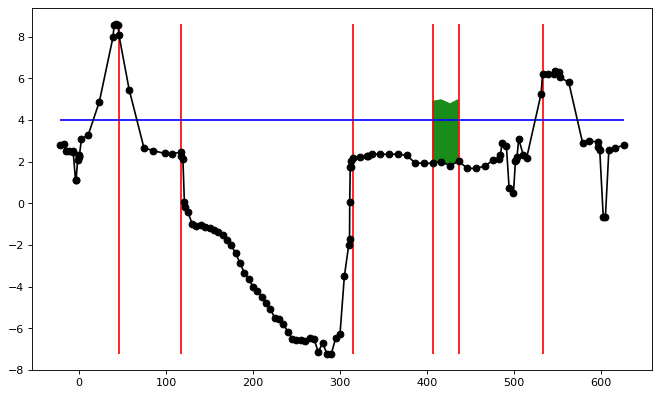

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6), dpi=80)
           
plt.plot(x,y, c='k', marker='o')
plt.vlines(x[div], ymin=y.min(), ymax=y.max(), color='r')

ind, = np.where(treeh > 0)
for i in ind : plt.fill_between(X[i], Y[i], Y[i] + treeh[i], facecolor='green', alpha=0.9)

plt.hlines(xmin=x.min(), xmax=x.max(), y=4, color='b') # water level
    
plt.show()

断面クラスsectionは以下のように定義する。

In [51]:
s = section(X, Y, N, 0, treeh, subsectBoundf, subsectBoundfd)
A,B,S,K,Rc = s.H2ABSKRc(1)
print('河積：{}\n水面幅：{}\n潤辺：{}\n通水能：{}'.format(A, B, S, K))

河積：976.1185958704697
水面幅：197.31749257278668
潤辺：201.6464283634635
通水能：113763.90119817555


 - ニュートン法が高速
 - H-Aのテーブルを作る方法もあり。
 - 同様に断面データを間引く方法も有効

In [52]:
%%timeit
s.A2H(A)

1.21 ms ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 課題3

不定流計算では以下の論文の計算方法を使用するため一読下さい。

https://ascelibrary.org/doi/10.1061/%28ASCE%290733-9429%282004%29130%3A10%28977%29

teamsに添付します。